# Can VGG16 and fine-tuning achieve what pigeons already did? 

### Context:
In a 2015 study, pigeons were trained to distinguish between benign and malignant medical images. Surprisingly, with enough training, they achieved an accuracy of around 85%, outperforming some radiologists on the same task.

If a bird with a brain the size of a fingertip can learn to recognize subtle visual patterns in medical images, what happens when we bring together math, large labeled datasets, and modern deep learning models?

In this notebook, I explore that question by fine-tuning a VGG16 convolutional neural network on a mammogram dataset. The goal isn’t to build a clinical tool or beat experts, but to understand how far transfer learning can go in a challenging medical image classification problem, and what it struggles with along the way.

Let's find out!


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision.transforms import transforms, InterpolationMode
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import kagglehub
from pathlib import Path

In [29]:
path = kagglehub.dataset_download("vuppalaadithyasairam/ultrasound-breast-images-for-breast-cancer")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\HP\.cache\kagglehub\datasets\vuppalaadithyasairam\ultrasound-breast-images-for-breast-cancer\versions\1


In [ ]:
# hyperparams

batch_size = 16
epochs = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dropout = 0.4
print(device)

In [31]:
imagenet_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

transforms = transforms.Compose(
    [transforms.Resize((224, 224), interpolation=InterpolationMode.BILINEAR, max_size=None, antialias=True),
     transforms.ToTensor(), 
     imagenet_normalize])

In [32]:
dataset_root = Path(path) / "ultrasound breast classification"

train_dataset = datasets.ImageFolder(
    root=dataset_root / "train",
    transform=transforms
)

test_dataset = datasets.ImageFolder(
    root=dataset_root / "val",
    transform=transforms
)

In [33]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [34]:
class_names = train_dataset.classes
class_names

['benign', 'malignant']

In [35]:
class vgg16(nn.Module):
    def __init__(self):
        super(vgg16, self).__init__()

        self.vgg16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights.IMAGENET1K_V1)
        self.vgg16.classifier[6] = nn.Sequential(
            nn.Linear(4096, 2048),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(2048, 1),
        )

    def forward(self, x):
        return self.vgg16(x)


CNN_model = vgg16().to(device)

In [36]:
for name, param in CNN_model.vgg16.features.named_parameters():
    param.requires_grad = False  


for param in CNN_model.vgg16.features[17:]: 
    param.requires_grad = True

In [37]:
def training_loop(model, data_loader, epochs, loss_fn, optimizer):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for X, Y in data_loader:
            X = X.to(device)
            Y = Y.to(device).unsqueeze(1).float()

            logits = model(X)
            loss = loss_fn(logits, Y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            correct += (preds == Y).sum().item()
            total += Y.size(0)

        acc = correct / total
        avg_loss = total_loss / len(data_loader)

        print(f"Epoch {epoch} | Loss: {avg_loss:.2f} | Accuracy: {acc:.2f}")
    return model



def testing_loop(model, data_loader, loss_fn):
    total_batches = len(data_loader)
    total_loss = 0
    total_acc = 0
    total = 0
    actual_lists = []
    predictions_lists = []
    model.eval()


    for batch, (X, Y) in enumerate(data_loader):
        X = X.to(device)
        Y = Y.to(device)

        with torch.no_grad():
            Y_pred = model(X)
            Y_unsq = Y.unsqueeze(1).float()
            loss = loss_fn(Y_pred, Y_unsq)
            total_loss += loss.item()


            probs = torch.sigmoid(Y_pred)
            predictions = (probs > 0.5).float()
            
            predictions_lists.append(predictions.squeeze(1).detach().cpu().numpy())
            actual_lists.append(Y.cpu().numpy())
            
            correct = (predictions == Y_unsq).sum().item()
            total += Y_unsq.size(0)
            total_acc += correct

    total_loss /= total_batches
    total_acc /= total
    
    predictions_arr = np.concatenate(predictions_lists)
    actual_arr = np.concatenate(actual_lists)
    
    report = classification_report(actual_arr, predictions_arr)
    matrix = confusion_matrix(actual_arr, predictions_arr)
    
    print(f"Loss: {total_loss:.2f} | Accuracy: {total_acc:.2f}")
    return report, matrix

In [38]:
loss_func = nn.CrossEntropyLoss()
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=CNN_model.parameters(), lr=0.0001)

In [39]:
trained_model = training_loop(CNN_model, train_loader, epochs, loss_func, optimizer)

Epoch 0 | Loss: 0.24 | Accuracy: 0.90
Epoch 1 | Loss: 0.08 | Accuracy: 0.97
Epoch 2 | Loss: 0.05 | Accuracy: 0.98
Epoch 3 | Loss: 0.04 | Accuracy: 0.99
Epoch 4 | Loss: 0.03 | Accuracy: 0.99
Epoch 5 | Loss: 0.03 | Accuracy: 0.99


In [40]:
report, matrix = testing_loop(trained_model, test_loader, loss_func)

Loss: 0.08 | Accuracy: 0.96


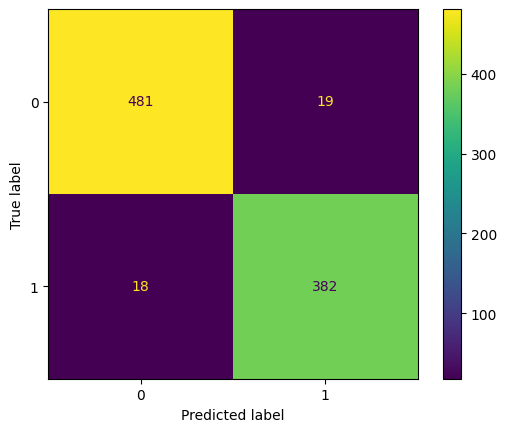

In [42]:
disp = ConfusionMatrixDisplay(matrix)
disp.plot()

In [43]:
print(report)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       500
           1       0.95      0.95      0.95       400

    accuracy                           0.96       900
   macro avg       0.96      0.96      0.96       900
weighted avg       0.96      0.96      0.96       900



# Wrapping up

I’ve included the confusion matrix from the trained model to better understand its performance, and overall, the results are encouraging, especially given the challenges of medical image classification and limited data.

This notebook is very much a work in progress, and I’m open to suggestions, critiques, and improvements. If you have ideas or feedback, feel free to reach out at charulabs@gmail.com

I’d also love to see how you might tweak or extend this notebook to push its limits further!